In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import torch
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Load the Dataset
file_path = '/content/EEG.machinelearing_data_BRMH.csv'
eeg_data = pd.read_csv(file_path)

# Step 2: Preprocessing
# Select only numerical columns
numerical_columns = eeg_data.select_dtypes(include=['float64', 'int64']).columns
eeg_numerical_data = eeg_data[numerical_columns]

# Handle Missing Values
# Drop columns with more than 50% missing values
threshold = 0.5 * len(eeg_numerical_data)
filtered_data = eeg_numerical_data.dropna(axis=1, thresh=threshold)

# Fill remaining missing values with column means
preprocessed_data = filtered_data.fillna(filtered_data.mean())

# Normalize the data to [0, 1] range
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(preprocessed_data)

# Step 3: Dimensionality Reduction using PCA
# Retain 95% of variance
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(normalized_data)

# Check reduced dimensionality
print(f"Reduced dimensionality: {pca_data.shape}")

# Step 4: Split the Data
# Split into train, validation, and test sets (80-10-10 split)
train_data, temp_data = train_test_split(pca_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Summarize the preprocessed data
print(f"Training data shape after PCA: {train_data.shape}")
print(f"Validation data shape after PCA: {val_data.shape}")
print(f"Test data shape after PCA: {test_data.shape}")

# Step 5: Convert to PyTorch Tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(test_tensor), batch_size=batch_size)


Reduced dimensionality: (945, 87)
Training data shape after PCA: (756, 87)
Validation data shape after PCA: (94, 87)
Test data shape after PCA: (95, 87)


In [2]:
import torch.nn as nn
import torch.optim as optim
# Step 6: Define the VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(64, latent_dim)
        self.logvar_layer = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

# Step 7: Train the VAE
input_dim = pca_data.shape[1]
latent_dim = 16
vae = VAE(input_dim, latent_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae.train()
num_epochs = 500
for epoch in range(num_epochs):
    train_loss = 0
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

print("VAE training complete.")

Epoch 1, Loss: 52.4343
Epoch 2, Loss: 43.7897
Epoch 3, Loss: 35.8906
Epoch 4, Loss: 33.7942
Epoch 5, Loss: 33.3308
Epoch 6, Loss: 33.1770
Epoch 7, Loss: 33.1110
Epoch 8, Loss: 33.0657
Epoch 9, Loss: 33.0530
Epoch 10, Loss: 33.0006
Epoch 11, Loss: 32.9529
Epoch 12, Loss: 32.9623
Epoch 13, Loss: 32.8693
Epoch 14, Loss: 32.4041
Epoch 15, Loss: 32.2018
Epoch 16, Loss: 32.0508
Epoch 17, Loss: 31.9765
Epoch 18, Loss: 31.8596
Epoch 19, Loss: 31.7557
Epoch 20, Loss: 31.8040
Epoch 21, Loss: 31.6775
Epoch 22, Loss: 31.7358
Epoch 23, Loss: 31.7490
Epoch 24, Loss: 31.6270
Epoch 25, Loss: 31.7433
Epoch 26, Loss: 31.7365
Epoch 27, Loss: 31.8133
Epoch 28, Loss: 31.6149
Epoch 29, Loss: 31.6914
Epoch 30, Loss: 31.6791
Epoch 31, Loss: 31.6319
Epoch 32, Loss: 31.5333
Epoch 33, Loss: 31.7968
Epoch 34, Loss: 31.7137
Epoch 35, Loss: 31.6537
Epoch 36, Loss: 31.6738
Epoch 37, Loss: 31.6320
Epoch 38, Loss: 31.6598
Epoch 39, Loss: 31.6400
Epoch 40, Loss: 31.5920
Epoch 41, Loss: 31.6232
Epoch 42, Loss: 31.6888
E

In [3]:
# Step 8: Evaluate Reconstruction Metrics
def evaluate_reconstruction(model, dataloader):
    model.eval()
    total_mse = 0
    total_mae = 0
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            recon_x, _, _ = model(x)
            total_mse += nn.functional.mse_loss(recon_x, x, reduction='sum').item()
            total_mae += nn.functional.l1_loss(recon_x, x, reduction='sum').item()

    mse = total_mse / len(dataloader.dataset)
    mae = total_mae / len(dataloader.dataset)
    return mse, mae

# Evaluate on the test set
test_mse, test_mae = evaluate_reconstruction(vae, test_loader)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Test MSE: 34.6419
Test MAE: 28.5752


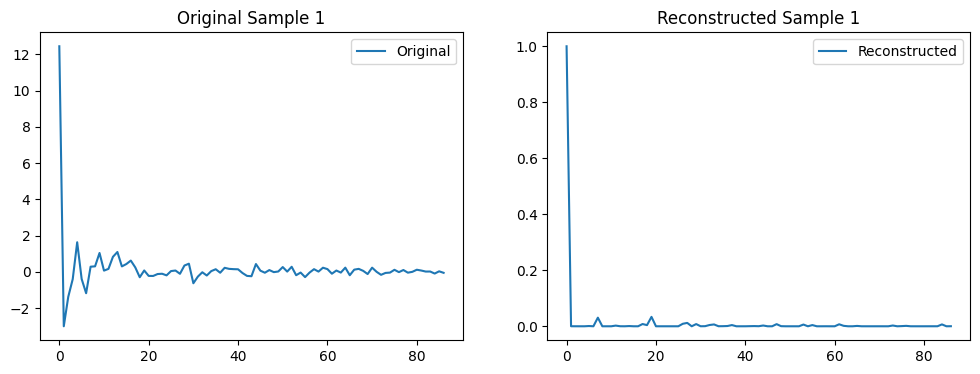

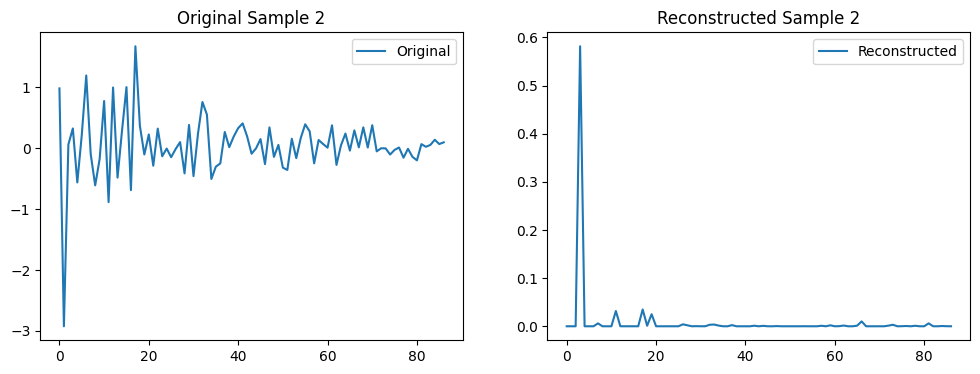

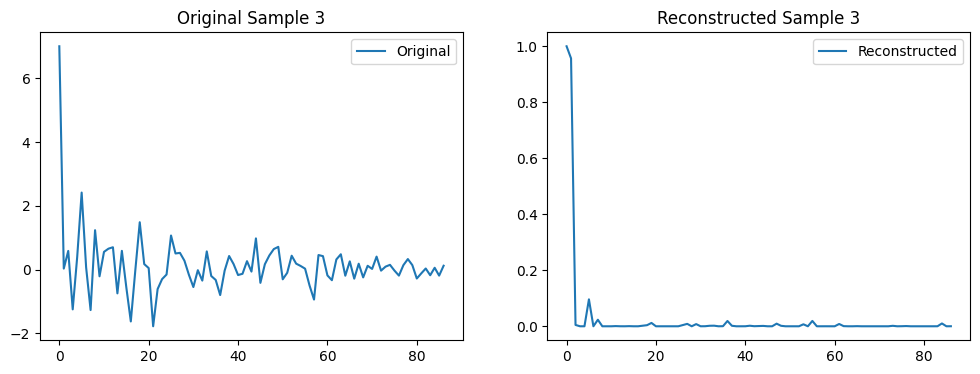

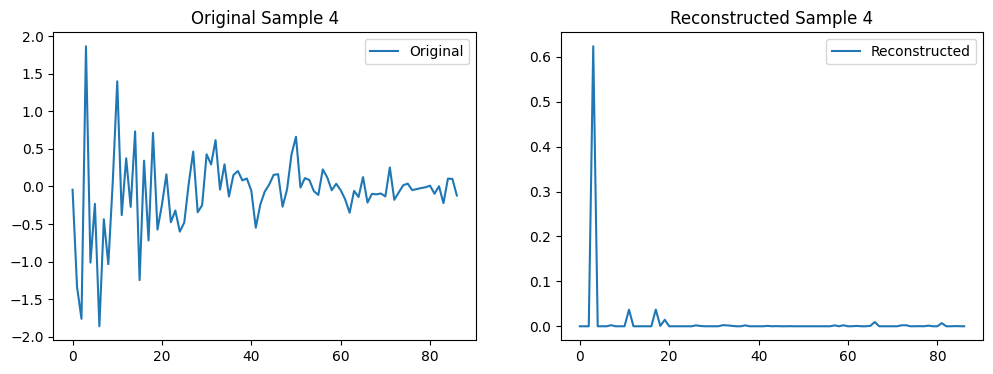

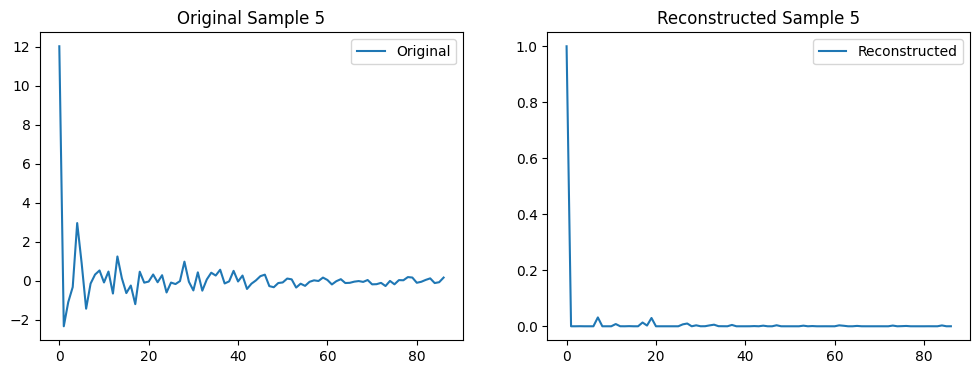

In [4]:
import matplotlib.pyplot as plt
# Step 9: Visualize Reconstruction Results
def visualize_reconstruction(model, dataloader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            x = batch[0].to(device)
            recon_x, _, _ = model(x)
            x = x.cpu().numpy()
            recon_x = recon_x.cpu().numpy()

            # Plot original and reconstructed samples
            for i in range(min(num_samples, len(x))):
                plt.figure(figsize=(12, 4))

                plt.subplot(1, 2, 1)
                plt.plot(x[i], label='Original')
                plt.title(f"Original Sample {i+1}")
                plt.legend()

                plt.subplot(1, 2, 2)
                plt.plot(recon_x[i], label='Reconstructed')
                plt.title(f"Reconstructed Sample {i+1}")
                plt.legend()

                plt.show()
            break

# Visualize reconstruction results on test data
visualize_reconstruction(vae, test_loader, num_samples=5)

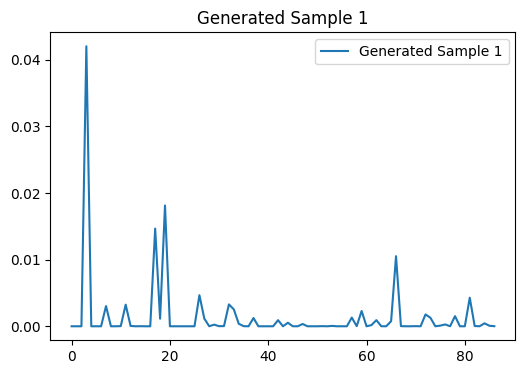

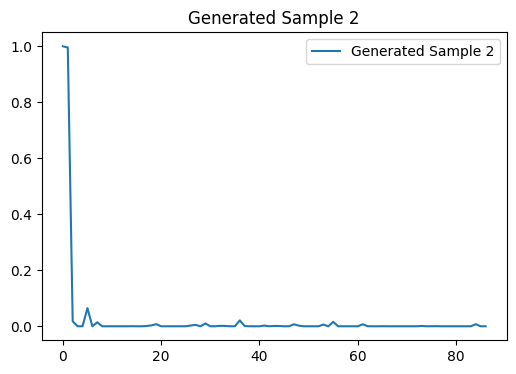

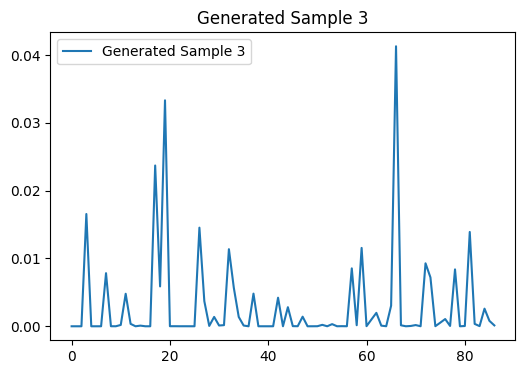

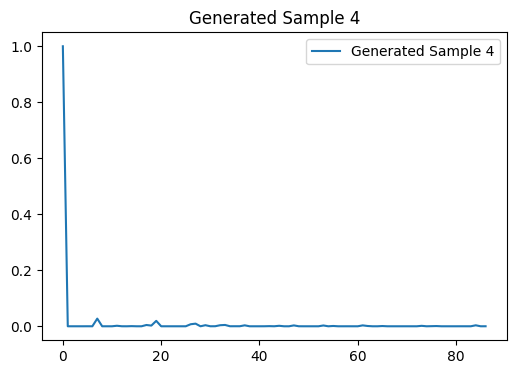

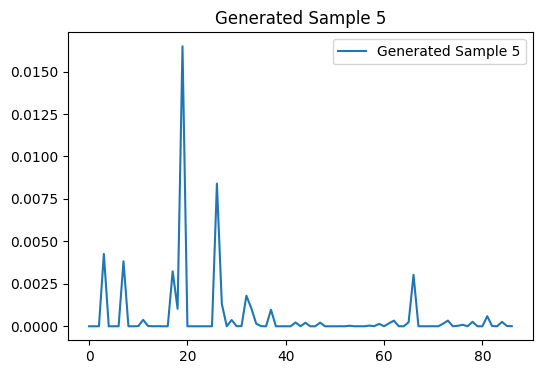

In [5]:
# Step 10: Generate New Samples from Latent Space
def generate_samples(model, latent_dim, num_samples=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Random latent vectors
        generated = model.decode(z).cpu().numpy()

        # Plot generated samples
        for i in range(num_samples):
            plt.figure(figsize=(6, 4))
            plt.plot(generated[i], label=f'Generated Sample {i+1}')
            plt.title(f"Generated Sample {i+1}")
            plt.legend()
            plt.show()

# Generate and visualize new samples
generate_samples(vae, latent_dim=latent_dim, num_samples=5)


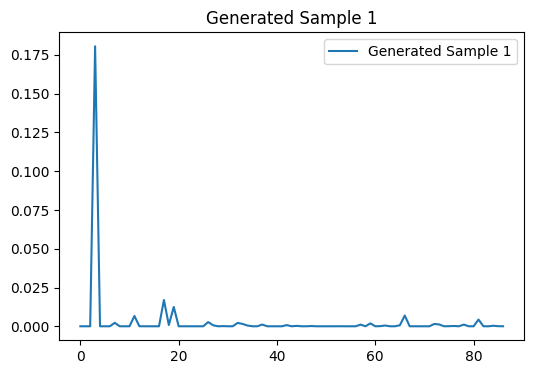

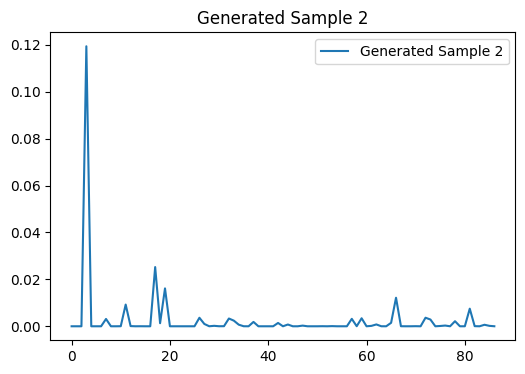

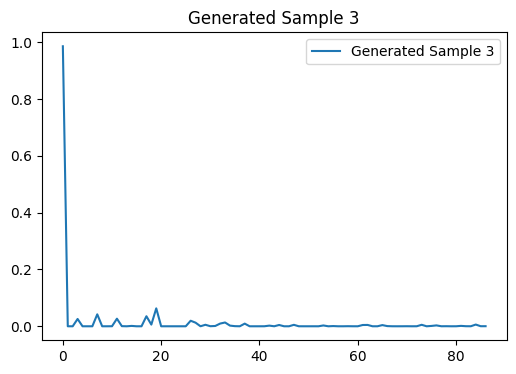

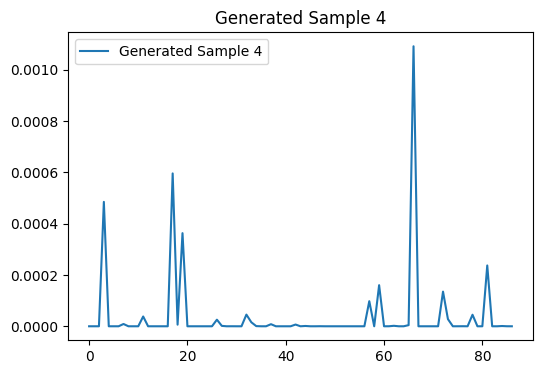

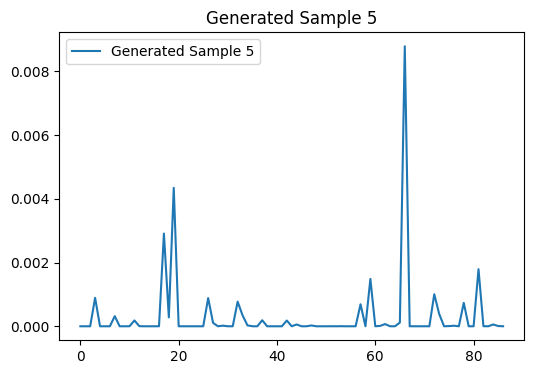

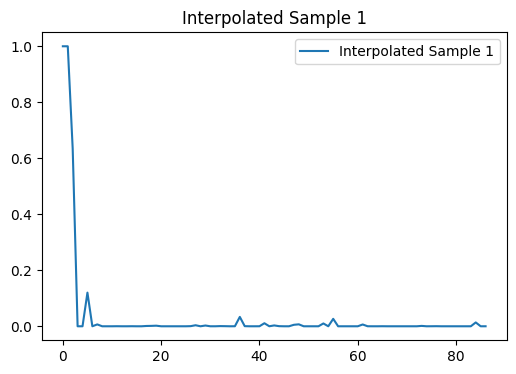

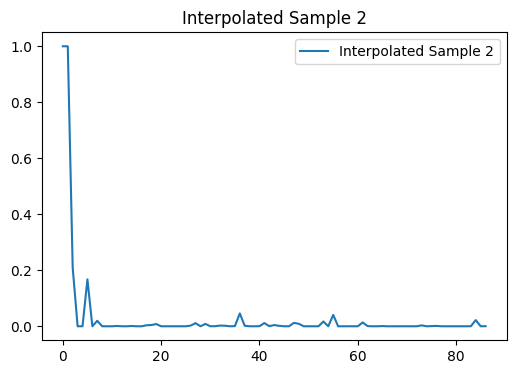

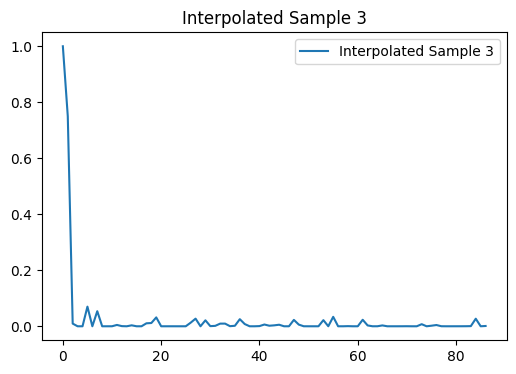

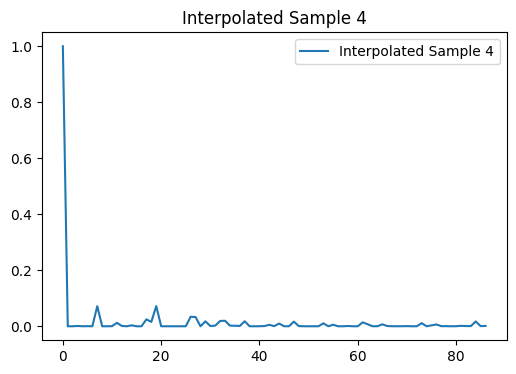

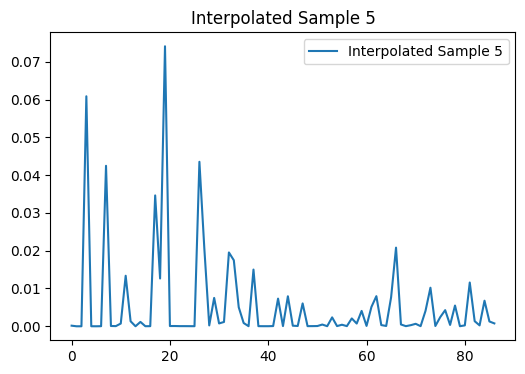

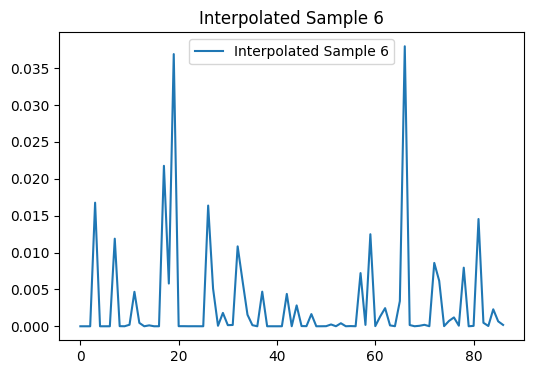

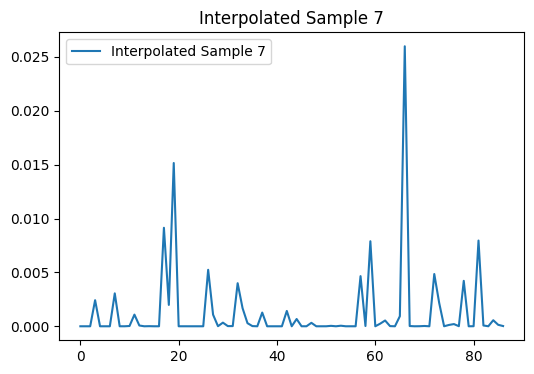

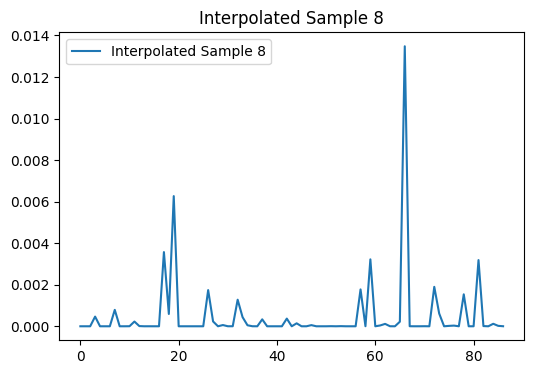

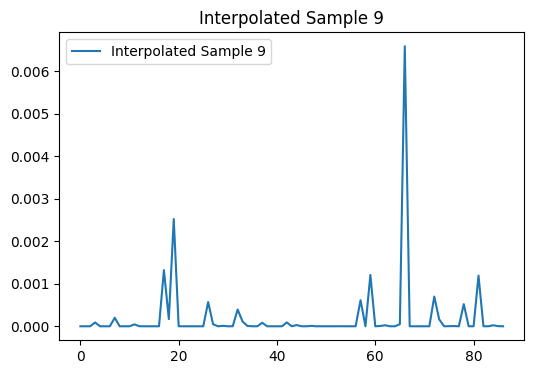

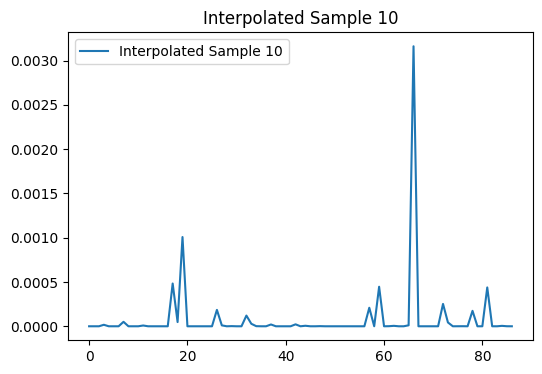

In [6]:
# Generate and visualize new samples
generate_samples(vae, latent_dim=latent_dim, num_samples=5)

# Step 11: Visualize Latent Space Interpolation
def visualize_latent_interpolation(model, latent_dim, num_steps=10):
    model.eval()
    with torch.no_grad():
        # Define two random latent vectors
        z_start = torch.randn(1, latent_dim).to(device)
        z_end = torch.randn(1, latent_dim).to(device)

        # Interpolate between the two latent vectors
        z_values = torch.linspace(0, 1, steps=num_steps).unsqueeze(1).to(device)
        interpolated_z = (1 - z_values) * z_start + z_values * z_end

        # Decode interpolated latent vectors
        interpolated_samples = model.decode(interpolated_z).cpu().numpy()

        # Plot interpolated samples
        for i, sample in enumerate(interpolated_samples):
            plt.figure(figsize=(6, 4))
            plt.plot(sample, label=f'Interpolated Sample {i+1}')
            plt.title(f"Interpolated Sample {i+1}")
            plt.legend()
            plt.show()

# Visualize latent space interpolation
visualize_latent_interpolation(vae, latent_dim=latent_dim, num_steps=10)


---



Main Disorder Counts:
main.disorder
Mood disorder                         266
Addictive disorder                    186
Trauma and stress related disorder    128
Schizophrenia                         117
Anxiety disorder                      107
Healthy control                        95
Obsessive compulsive disorder          46
Name: count, dtype: int64
Secondary Disorder Counts:
specific.disorder
Depressive disorder               199
Schizophrenia                     117
Healthy control                    95
Alcohol use disorder               93
Behavioral addiction disorder      93
Bipolar disorder                   67
Panic disorder                     59
Posttraumatic stress disorder      52
Social anxiety disorder            48
Obsessive compulsitve disorder     46
Acute stress disorder              38
Adjustment disorder                38
Name: count, dtype: int64


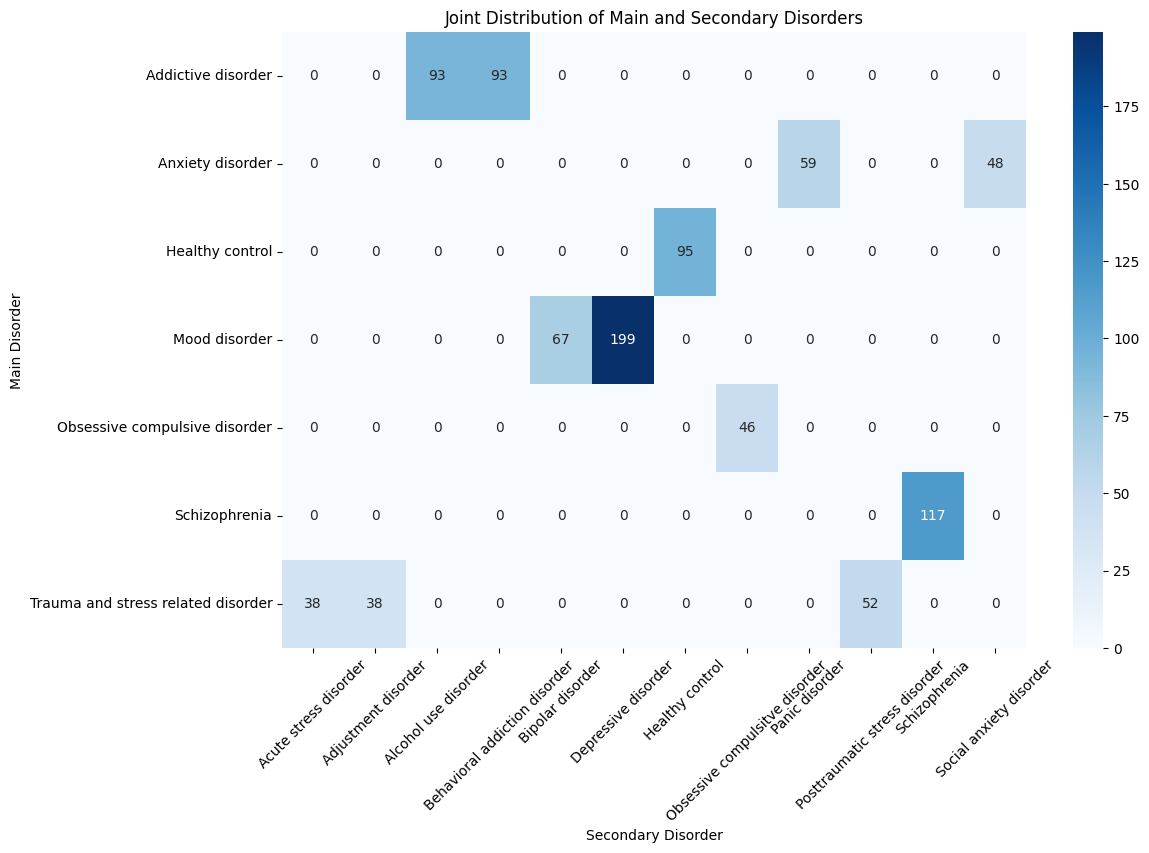

Pairwise Disorder Relationships:
                         main.disorder               specific.disorder  Count
0                        Mood disorder             Depressive disorder    199
1                        Schizophrenia                   Schizophrenia    117
2                      Healthy control                 Healthy control     95
3                   Addictive disorder            Alcohol use disorder     93
4                   Addictive disorder   Behavioral addiction disorder     93
5                        Mood disorder                Bipolar disorder     67
6                     Anxiety disorder                  Panic disorder     59
7   Trauma and stress related disorder   Posttraumatic stress disorder     52
8                     Anxiety disorder         Social anxiety disorder     48
9        Obsessive compulsive disorder  Obsessive compulsitve disorder     46
10  Trauma and stress related disorder           Acute stress disorder     38
11  Trauma and stress related d

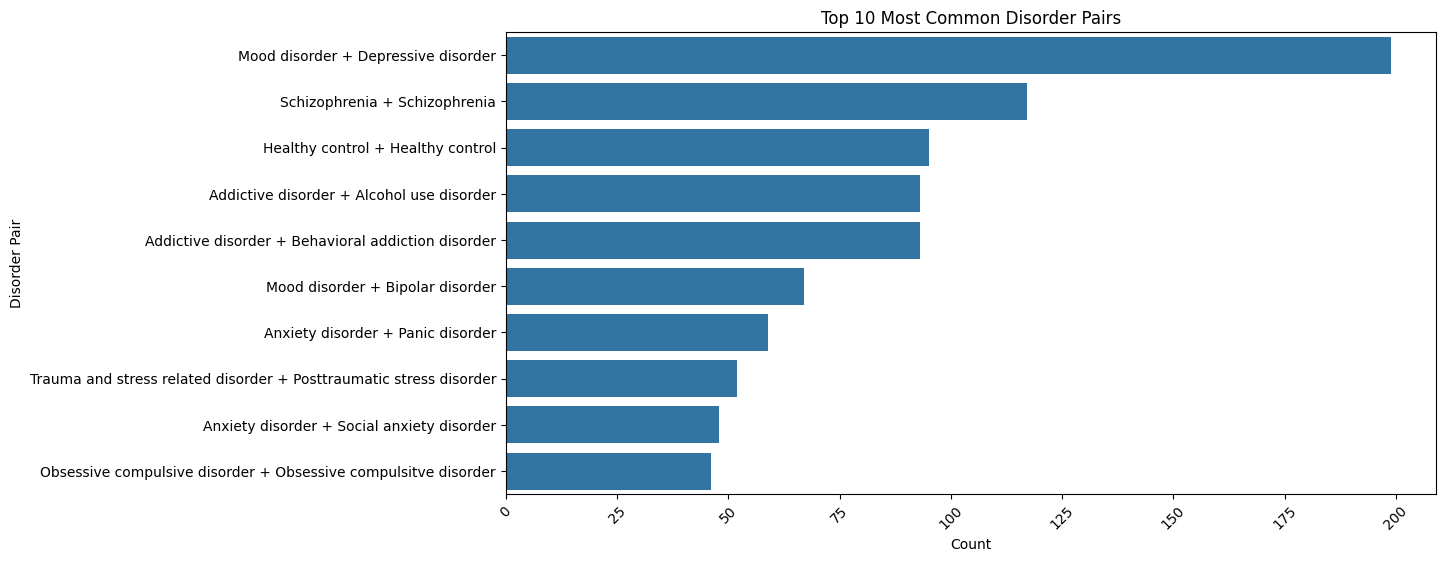

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Dataset
file_path = '/content/EEG.machinelearing_data_BRMH.csv'
eeg_data = pd.read_csv(file_path)

# Step 1: Check for Disorder Columns
if 'main.disorder' in eeg_data.columns and 'specific.disorder' in eeg_data.columns:
    main_disorder_col = 'main.disorder'
    secondary_disorder_col = 'specific.disorder'
else:
    raise ValueError("The dataset does not contain 'main disorder' and 'secondary disorder' columns.")

# Step 2: Explore Disorder Relationships
# Count unique values for both main and secondary disorders
main_disorder_counts = eeg_data[main_disorder_col].value_counts()
secondary_disorder_counts = eeg_data[secondary_disorder_col].value_counts()

# Display counts
print("Main Disorder Counts:")
print(main_disorder_counts)

print("Secondary Disorder Counts:")
print(secondary_disorder_counts)

# Step 3: Joint Distribution of Main and Secondary Disorders
joint_disorder_counts = eeg_data.groupby([main_disorder_col, secondary_disorder_col]).size().unstack(fill_value=0)

# Visualize joint distribution as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(joint_disorder_counts, annot=True, fmt="d", cmap="Blues")
plt.title("Joint Distribution of Main and Secondary Disorders")
plt.xlabel("Secondary Disorder")
plt.ylabel("Main Disorder")
plt.xticks(rotation=45)
plt.show()

# Step 4: Pairwise Disorder Relationships
# Check if there are common patterns or correlations between main and secondary disorders
def disorder_relationship_analysis(df, main_col, secondary_col):
    combined_disorders = df[[main_col, secondary_col]].value_counts()
    total_disorders = combined_disorders.reset_index()
    total_disorders.columns = [main_col, secondary_col, 'Count']
    return total_disorders

disorder_relationships = disorder_relationship_analysis(eeg_data, main_disorder_col, secondary_disorder_col)
print("Pairwise Disorder Relationships:")
print(disorder_relationships)

# Step 5: Visualize Most Common Pairings
plt.figure(figsize=(12, 6))
most_common_pairs = disorder_relationships.sort_values(by='Count', ascending=False).head(10)
most_common_pairs['Disorder Pair'] = most_common_pairs[main_disorder_col] + " + " + most_common_pairs[secondary_disorder_col]
sns.barplot(x='Count', y='Disorder Pair', data=most_common_pairs)
plt.title("Top 10 Most Common Disorder Pairs")
plt.xlabel("Count")
plt.ylabel("Disorder Pair")
plt.xticks(rotation=45)
plt.show()


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# One-hot encode main and secondary disorders
ohe = OneHotEncoder(sparse_output=False)
condition_matrix = ohe.fit_transform(eeg_data[[main_disorder_col, secondary_disorder_col]])

# Separate numerical features
numerical_columns = eeg_data.select_dtypes(include=['float64', 'int64']).columns
features = eeg_data[numerical_columns].values

# Check for NaNs in features and replace with column means
features = np.nan_to_num(features, nan=np.nanmean(features, axis=0))

# Combine features and conditions
X = features
y = condition_matrix

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Step 3: Define the CVAE Model
class CVAE(nn.Module):
    def __init__(self, input_dim, condition_dim, latent_dim):
        super(CVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(64, latent_dim)
        self.logvar_layer = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        h = self.encoder(torch.cat([x, c], dim=1))
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        return self.decoder(torch.cat([z, c], dim=1))

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

# Loss function for CVAE
def cvae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

# Step 4: Train the CVAE
input_dim = X_train.shape[1]
condition_dim = y_train.shape[1]
latent_dim = 16

cvae = CVAE(input_dim, condition_dim, latent_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cvae.train()
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = 0
    for batch in train_loader:
        x, c = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = cvae(x, c)
        loss = cvae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset):.4f}")

print("CVAE training complete.")

# Step 5: Generate Conditioned Samples
def generate_samples(model, condition, num_samples=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        c = torch.tensor(condition, dtype=torch.float32).repeat(num_samples, 1).to(device)
        generated = model.decode(z, c).cpu().numpy()
    return generated

# Example: Generate samples for a specific condition
sample_condition = y_test[0]  # Use the first test condition
generated_samples = generate_samples(cvae, sample_condition, num_samples=5)
print("Generated Samples:")
print(generated_samples)


<ipython-input-8-8a448813390b>:21: RuntimeWarning: Mean of empty slice
  features = np.nan_to_num(features, nan=np.nanmean(features, axis=0))


Epoch 1, Loss: nan
Epoch 2, Loss: nan
Epoch 3, Loss: nan
Epoch 4, Loss: nan
Epoch 5, Loss: nan
Epoch 6, Loss: nan
Epoch 7, Loss: nan
Epoch 8, Loss: nan
Epoch 9, Loss: nan
Epoch 10, Loss: nan
Epoch 11, Loss: nan
Epoch 12, Loss: nan
Epoch 13, Loss: nan
Epoch 14, Loss: nan
Epoch 15, Loss: nan
Epoch 16, Loss: nan
Epoch 17, Loss: nan
Epoch 18, Loss: nan
Epoch 19, Loss: nan
Epoch 20, Loss: nan
Epoch 21, Loss: nan
Epoch 22, Loss: nan
Epoch 23, Loss: nan
Epoch 24, Loss: nan
Epoch 25, Loss: nan
Epoch 26, Loss: nan
Epoch 27, Loss: nan
Epoch 28, Loss: nan
Epoch 29, Loss: nan
Epoch 30, Loss: nan
Epoch 31, Loss: nan
Epoch 32, Loss: nan
Epoch 33, Loss: nan
Epoch 34, Loss: nan
Epoch 35, Loss: nan
Epoch 36, Loss: nan
Epoch 37, Loss: nan
Epoch 38, Loss: nan
Epoch 39, Loss: nan
Epoch 40, Loss: nan
Epoch 41, Loss: nan
Epoch 42, Loss: nan
Epoch 43, Loss: nan
Epoch 44, Loss: nan
Epoch 45, Loss: nan
Epoch 46, Loss: nan
Epoch 47, Loss: nan
Epoch 48, Loss: nan
Epoch 49, Loss: nan
Epoch 50, Loss: nan
CVAE trai

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Load Dataset
file_path = '/content/EEG.machinelearing_data_BRMH.csv'
data = pd.read_csv(file_path)

# Step 1: Extract Columns
# Metadata
metadata_columns = ['sex', 'age', 'education', 'IQ']

# Condition Columns
condition_columns = ['main.disorder', 'specific.disorder']

# Time-Series Columns
time_series_columns = [col for col in data.columns if col.startswith('AB.') or col.startswith('COH.')]

# Step 2: Preprocess Conditions
ohe = OneHotEncoder(sparse_output=False)
condition_matrix = ohe.fit_transform(data[condition_columns])

# Step 3: Normalize Time-Series Data
scaler = MinMaxScaler()
time_series_data = scaler.fit_transform(data[time_series_columns])

# Step 4: Reshape Time-Series Data
seq_length = len(time_series_columns)  # Number of time steps
time_series_data = time_series_data.reshape(-1, seq_length, 1)  # Shape: (samples, sequence_length, features)

# Step 5: Split Data
X_train, X_test, y_train, y_test = train_test_split(time_series_data, condition_matrix, test_size=0.2, random_state=42)

# Step 6: Convert to PyTorch Tensors
import torch
from torch.utils.data import DataLoader, TensorDataset

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


Epoch 1, Total Loss: 236.8683, Reconstruction Loss: 236.7786, KL Divergence: 0.1794
Epoch 2, Total Loss: 101.7933, Reconstruction Loss: 101.5487, KL Divergence: 0.4893
Epoch 3, Total Loss: 85.7092, Reconstruction Loss: 85.3811, KL Divergence: 0.6562
Epoch 4, Total Loss: 82.9936, Reconstruction Loss: 82.6876, KL Divergence: 0.6119
Epoch 5, Total Loss: 81.4103, Reconstruction Loss: 81.1125, KL Divergence: 0.5957
Epoch 6, Total Loss: 81.5170, Reconstruction Loss: 81.2268, KL Divergence: 0.5803
Epoch 7, Total Loss: 80.7290, Reconstruction Loss: 80.4441, KL Divergence: 0.5698
Epoch 8, Total Loss: 80.6633, Reconstruction Loss: 80.3792, KL Divergence: 0.5683
Epoch 9, Total Loss: 80.5886, Reconstruction Loss: 80.3005, KL Divergence: 0.5762
Epoch 10, Total Loss: 80.2664, Reconstruction Loss: 79.9673, KL Divergence: 0.5983
Epoch 11, Total Loss: 80.0255, Reconstruction Loss: 79.7188, KL Divergence: 0.6135
Epoch 12, Total Loss: 79.8334, Reconstruction Loss: 79.5227, KL Divergence: 0.6213
Epoch 13,

<ipython-input-10-b8f3ee730749>:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(condition, dtype=torch.float32).repeat(num_samples, 1).to(device)


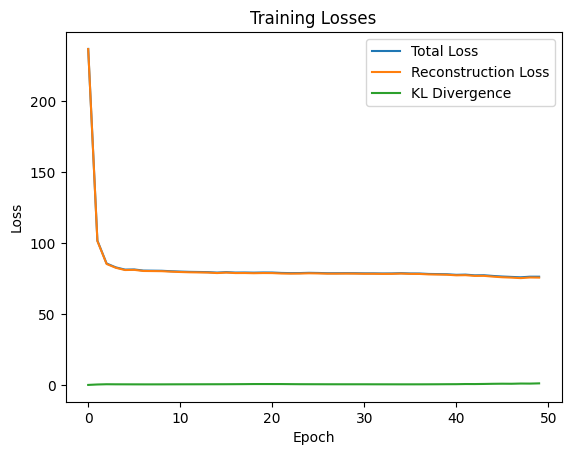

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Step 1: Define the Time-Series CVAE Model
class TimeSeriesCVAE(nn.Module):
    def __init__(self, seq_length, condition_dim, latent_dim):
        super(TimeSeriesCVAE, self).__init__()

        # Hidden size for the LSTM
        self.hidden_size = 64

        # Encoder
        self.encoder_lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size, batch_first=True)
        self.fc_mu = nn.Linear(self.hidden_size + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.hidden_size + condition_dim, latent_dim)
        self.encoder_dropout = nn.Dropout(0.2)

        # Decoder
        self.decoder_lstm = nn.LSTM(input_size=latent_dim + condition_dim, hidden_size=self.hidden_size, batch_first=True)
        self.decoder_output = nn.Linear(self.hidden_size, 1)
        self.decoder_dropout = nn.Dropout(0.2)

    def encode(self, x, c):
        _, (h, _) = self.encoder_lstm(x)  # h: (1, batch_size, hidden_size)
        h = h.squeeze(0)  # Shape: (batch_size, hidden_size)
        h = self.encoder_dropout(h)  # Apply dropout
        h = torch.cat([h, c], dim=1)  # Concatenate condition vector
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, seq_length):
        z = z.unsqueeze(1).repeat(1, seq_length, 1)  # Repeat latent vector for each time step
        c = c.unsqueeze(1).repeat(1, seq_length, 1)  # Repeat condition vector for each time step
        zc = torch.cat([z, c], dim=2)  # Shape: (batch_size, seq_length, latent_dim + condition_dim)
        output, _ = self.decoder_lstm(zc)
        output = self.decoder_dropout(output)  # Apply dropout
        return self.decoder_output(output)  # Shape: (batch_size, seq_length, 1)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c, x.size(1)), mu, logvar

# Step 2: Loss Function for CVAE with KL Divergence Scaling (Beta-VAE)
def cvae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_divergence, recon_loss, kl_divergence

# Step 3: Train the CVAE
seq_length = 120  # Example: Adjust based on your time-series columns
condition_dim = 19  # Example: Number of one-hot encoded condition features
latent_dim = 16

cvae = TimeSeriesCVAE(seq_length, condition_dim, latent_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dummy DataLoader Setup (replace with real data)
# Replace X_train_tensor, y_train_tensor with preprocessed data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Tracking losses
train_loss_history = []
recon_loss_history = []
kl_loss_history = []

cvae.train()
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0

    for batch in train_loader:
        x, c = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = cvae(x, c)
        loss, recon_loss, kl_loss = cvae_loss(recon_x, x, mu, logvar, beta=0.5)  # Adjust beta as needed
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()

    scheduler.step()

    # Log epoch losses
    train_loss_history.append(train_loss / len(train_loader.dataset))
    recon_loss_history.append(recon_loss_total / len(train_loader.dataset))
    kl_loss_history.append(kl_loss_total / len(train_loader.dataset))

    print(f"Epoch {epoch+1}, Total Loss: {train_loss / len(train_loader.dataset):.4f}, "
          f"Reconstruction Loss: {recon_loss_total / len(train_loader.dataset):.4f}, "
          f"KL Divergence: {kl_loss_total / len(train_loader.dataset):.4f}")

print("Time-Series CVAE training complete.")

# Step 4: Generate Conditioned Time-Series Samples
def generate_samples(model, condition, seq_length, num_samples=5):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        c = torch.tensor(condition, dtype=torch.float32).repeat(num_samples, 1).to(device)
        generated = model.decode(z, c, seq_length).cpu().numpy()
    return generated

# Example: Generate samples for a specific condition
sample_condition = y_train_tensor[0]  # Use a sample condition
generated_samples = generate_samples(cvae, sample_condition, seq_length, num_samples=5)
print("Generated Time-Series Samples:")
print(generated_samples)

# Step 5: Plot Training Losses
plt.plot(train_loss_history, label='Total Loss')
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()


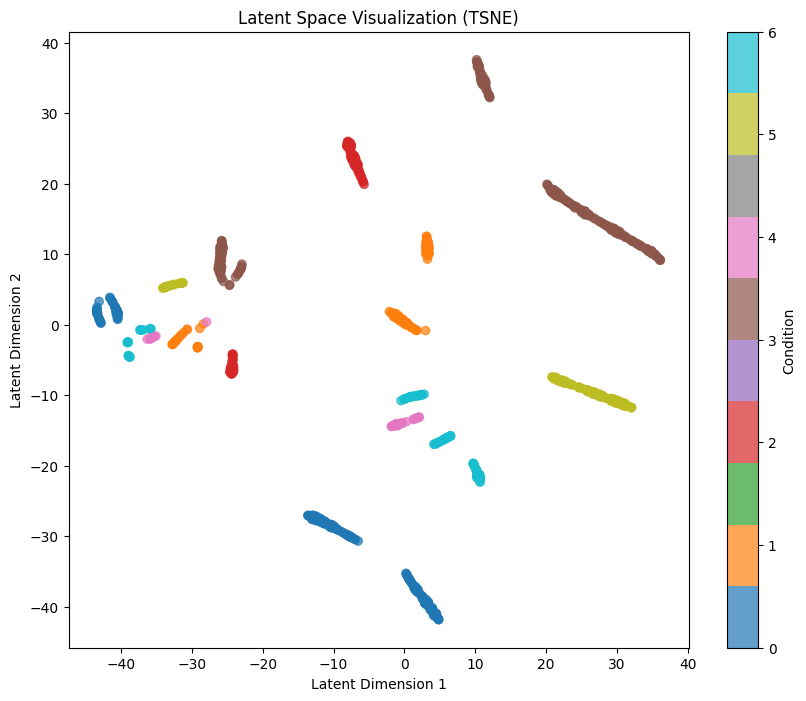

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

def visualize_latent_space(model, data_loader, condition_labels, reduction_method='tsne'):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            x, c = batch[0].to(device), batch[1].to(device)
            mu, _ = model.encode(x, c)  # Get latent space means
            latent_vectors.append(mu.cpu().numpy())
            labels.append(c.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Dimensionality Reduction
    if reduction_method == 'tsne':
        reduced_latents = TSNE(n_components=2).fit_transform(latent_vectors)
    elif reduction_method == 'pca':
        reduced_latents = PCA(n_components=2).fit_transform(latent_vectors)
    else:
        raise ValueError("Invalid reduction_method. Choose 'tsne' or 'pca'.")

    # Plot the Latent Space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_latents[:, 0],
        reduced_latents[:, 1],
        c=np.argmax(labels, axis=1),  # Assuming one-hot encoding of labels
        cmap='tab10',
        alpha=0.7
    )
    plt.colorbar(scatter, label="Condition")
    plt.title(f"Latent Space Visualization ({reduction_method.upper()})")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()

# Example Usage
visualize_latent_space(cvae, train_loader, y_train, reduction_method='tsne')

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

def compute_dci(latent_vectors, labels):
    """
    Compute DCI metrics (Disentanglement, Completeness, Informativeness).

    Parameters:
    - latent_vectors: Numpy array of shape (num_samples, latent_dim)
    - labels: Numpy array of shape (num_samples, num_factors) with target factors

    Returns:
    - metrics: Dictionary containing disentanglement, completeness, and informativeness
    """
    num_latent_dims = latent_vectors.shape[1]
    num_factors = labels.shape[1]

    importance_matrix = np.zeros((num_latent_dims, num_factors))
    informativeness_scores = []

    for i in range(num_factors):
        # Train a logistic regression model for each factor
        factor_labels = labels[:, i]
        model = LogisticRegression(max_iter=1000)
        model.fit(latent_vectors, factor_labels)

        # Record importance scores (coefficients)
        importance_matrix[:, i] = np.abs(model.coef_).mean(axis=0)

        # Compute informativeness (accuracy)
        predictions = model.predict(latent_vectors)
        informativeness_scores.append(accuracy_score(factor_labels, predictions))

    # Normalize importance matrix
    importance_matrix /= importance_matrix.sum(axis=0, keepdims=True)

    # Disentanglement
    disentanglement_scores = 1.0 - importance_matrix.var(axis=1)
    disentanglement = disentanglement_scores.mean()

    # Completeness
    completeness_scores = 1.0 - importance_matrix.var(axis=0)
    completeness = completeness_scores.mean()

    # Informativeness
    informativeness = np.mean(informativeness_scores)

    return {
        "disentanglement": disentanglement,
        "completeness": completeness,
        "informativeness": informativeness
    }

# Example Usage
cvae.eval()
latent_vectors = []
labels = []

# Extract latent representations and labels
with torch.no_grad():
    for batch in train_loader:
        x, c = batch[0].to(device), batch[1].to(device)
        mu, _ = cvae.encode(x, c)
        latent_vectors.append(mu.cpu().numpy())
        labels.append(c.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

# Compute DCI metrics
dci_metrics = compute_dci(latent_vectors, labels)
print("DCI Metrics:", dci_metrics)


DCI Metrics: {'disentanglement': 0.9982589564985695, 'completeness': 0.9981388351312797, 'informativeness': 0.9584377610693401}


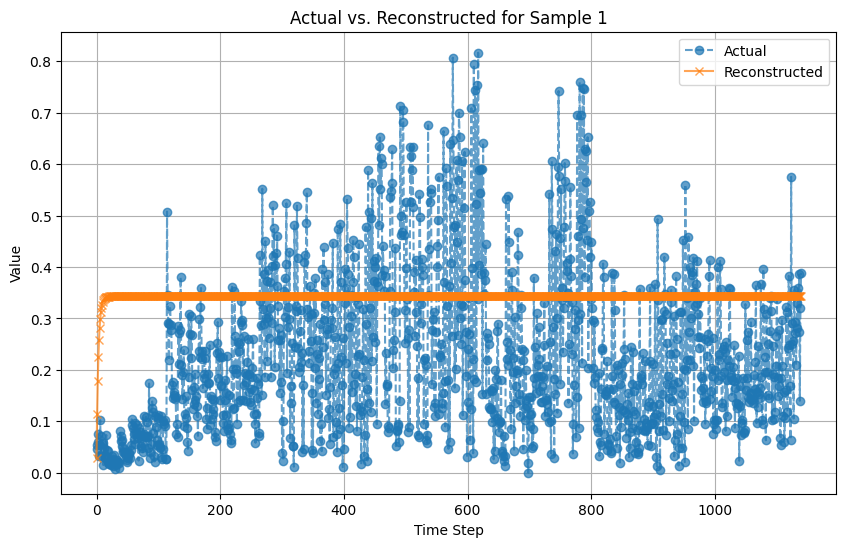

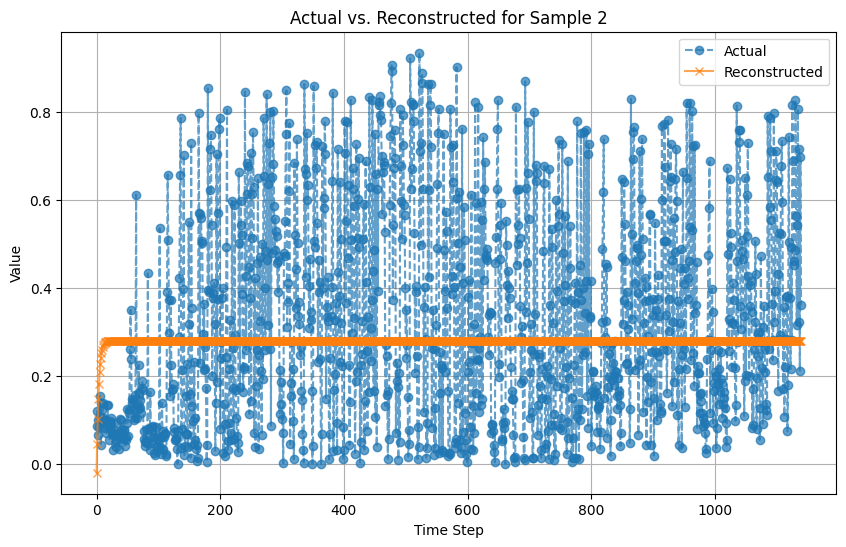

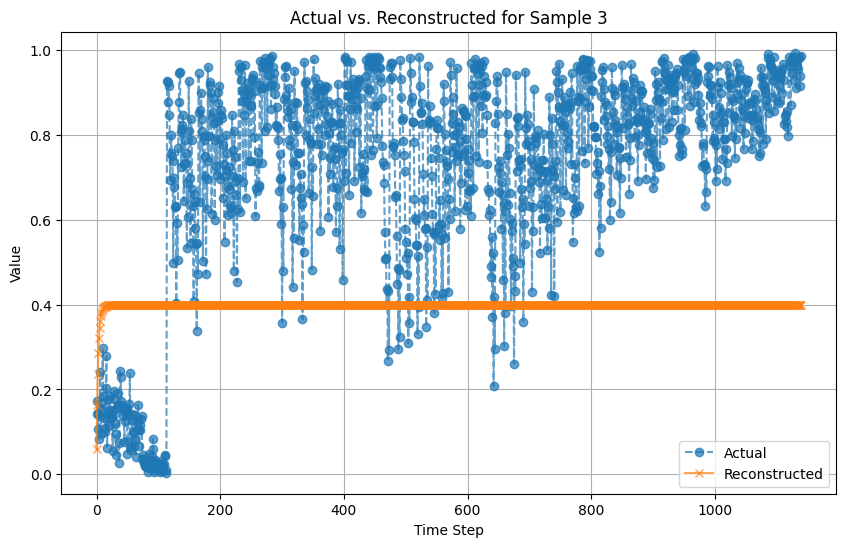

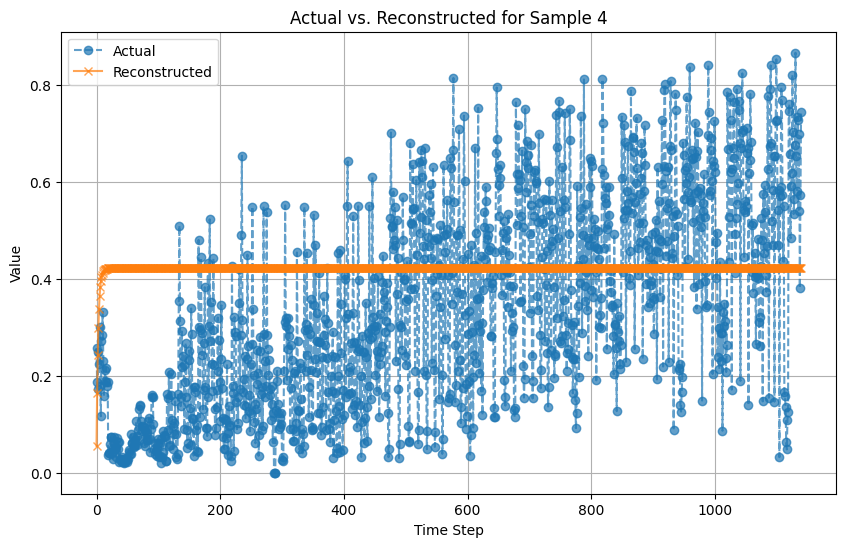

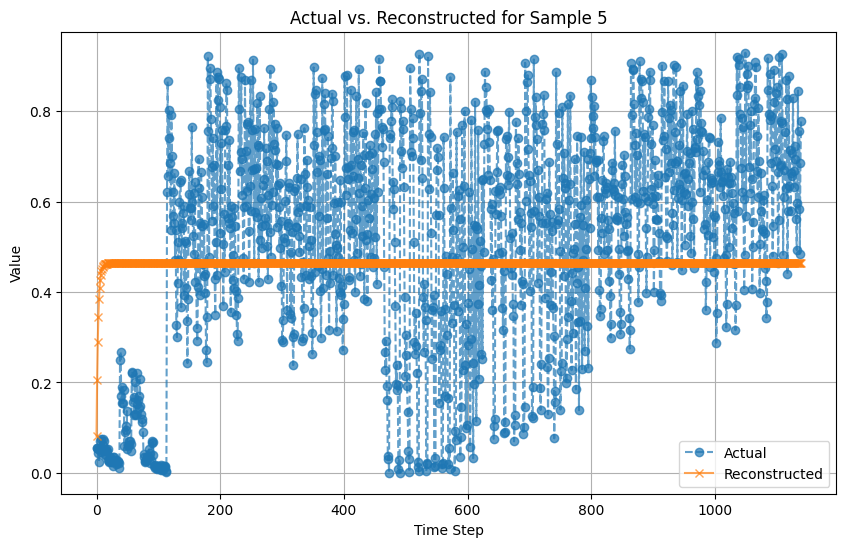

In [13]:
import matplotlib.pyplot as plt

def visualize_actual_vs_reconstructed(model, data_loader, condition_name, num_samples=5):
    """
    Visualize actual and reconstructed time-series data for a specific condition.

    Parameters:
    - model: Trained CVAE model
    - data_loader: DataLoader for the dataset
    - condition_name: Name of the condition to filter
    - num_samples: Number of samples to visualize
    """
    model.eval()
    actual_data = []
    reconstructed_data = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            x, c = batch[0].to(device), batch[1].to(device)

            # Find samples for the specific condition
            condition_mask = c[:, condition_name] == 1  # Adjust for specific one-hot encoding index
            if condition_mask.sum() == 0:
                continue

            filtered_x = x[condition_mask]
            filtered_c = c[condition_mask]

            # Reconstruct
            recon_x, _, _ = model(filtered_x, filtered_c)

            actual_data.append(filtered_x.cpu().numpy())
            reconstructed_data.append(recon_x.cpu().numpy())
            labels.append(filtered_c.cpu().numpy())

            # Break if enough samples are collected
            if len(actual_data) >= num_samples:
                break

    # Convert lists to arrays
    actual_data = np.concatenate(actual_data, axis=0)
    reconstructed_data = np.concatenate(reconstructed_data, axis=0)

    # Plot actual vs reconstructed
    for i in range(num_samples):
        plt.figure(figsize=(10, 6))
        plt.plot(actual_data[i].squeeze(), label="Actual", linestyle="--", marker="o", alpha=0.7)
        plt.plot(reconstructed_data[i].squeeze(), label="Reconstructed", linestyle="-", marker="x", alpha=0.7)
        plt.title(f"Actual vs. Reconstructed for Sample {i+1}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()
        plt.show()

# Example Usage
condition_index = 0  # Replace with the index for a specific disorder
visualize_actual_vs_reconstructed(cvae, test_loader, condition_name=condition_index, num_samples=5)


In [14]:
# Step 1: Normalize Input Data for Time-Series
def normalize_time_series(data):
    """
    Normalize 3D time-series data (samples, timesteps, features).
    Flattens, scales, and reshapes the data.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    num_samples, timesteps, features = data.shape

    # Flatten to 2D: (samples * timesteps, features)
    data_2d = data.reshape(-1, features)

    # Scale
    data_scaled = scaler.fit_transform(data_2d)

    # Reshape back to 3D
    data_3d = data_scaled.reshape(num_samples, timesteps, features)
    return data_3d, scaler

# Normalize Train and Test Data
X_train_normalized, scaler = normalize_time_series(X_train)
X_test_normalized, _ = normalize_time_series(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [23]:
# Step 2: Define the Updated CVAE Model
class TimeSeriesCVAE(nn.Module):
    def __init__(self, seq_length, condition_dim, latent_dim):
        super(TimeSeriesCVAE, self).__init__()
        self.hidden_size = 128  # Increased hidden size

        # Encoder
        self.encoder_lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size,
                                    num_layers=2, batch_first=True, dropout=0.2)
        self.fc_mu = nn.Linear(self.hidden_size + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.hidden_size + condition_dim, latent_dim)

        # Decoder
        self.decoder_lstm = nn.LSTM(input_size=latent_dim + condition_dim, hidden_size=self.hidden_size,
                                    num_layers=2, batch_first=True, dropout=0.2)
        self.decoder_output = nn.Linear(self.hidden_size, 1)

    def encode(self, x, c):
        _, (h, _) = self.encoder_lstm(x)
        h = h[-1]  # Take the last hidden state
        h = torch.cat([h, c], dim=1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, seq_length):
        z = z.unsqueeze(1).repeat(1, seq_length, 1)
        c = c.unsqueeze(1).repeat(1, seq_length, 1)
        zc = torch.cat([z, c], dim=2)
        output, _ = self.decoder_lstm(zc)
        return self.decoder_output(output)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c, x.size(1)), mu, logvar

# Step 3: Loss Function
def cvae_loss(recon_x, x, mu, logvar, beta=0.1):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='mean')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + beta * kl_divergence

# Step 4: Train the Updated CVAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seq_length = X_train_tensor.shape[1]  # Number of time steps
condition_dim = y_train_tensor.shape[1]
latent_dim = 16

cvae = TimeSeriesCVAE(seq_length, condition_dim, latent_dim).to(device)
optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5)

cvae.train()
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = 0
    for batch in train_loader:
        x, c = batch[0].to(device), batch[1].to(device) # Add channel dimension
        optimizer.zero_grad()
        recon_x, mu, logvar = cvae(x, c)
        loss = cvae_loss(recon_x, x, mu, logvar, beta=0.1)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    scheduler.step(train_loss)
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(train_loader):.4f}")

print("Training complete.")

# Step 5: Visualize Actual vs Reconstructed Data as Heatmaps
def visualize_actual_vs_reconstructed(model, data_loader, num_samples=5):
    model.eval()
    actual_data = []
    reconstructed_data = []

    with torch.no_grad():
        for batch in data_loader:
            x, c = batch[0].to(device), batch[1].to(device)
            recon_x, _, _ = model(x, c)
            actual_data.append(x.cpu().numpy())
            reconstructed_data.append(recon_x.cpu().numpy())
            if len(actual_data) >= num_samples:
                break

    actual_data = np.concatenate(actual_data, axis=0)
    reconstructed_data = np.concatenate(reconstructed_data, axis=0)


    print(actual_data.shape)
    print(reconstructed_data.shape)

    for i in range(num_samples):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        sns.heatmap(actual_data[i, :, :], cmap='viridis', cbar=True)
        plt.title(f"Actual Data (Sample {i+1})")
        plt.subplot(1, 2, 2)
        sns.heatmap(reconstructed_data[i, :, :], cmap='viridis', cbar=True)
        plt.title(f"Reconstructed Data (Sample {i+1})")
        plt.show()


# visualise reconstructions
visualize_actual_vs_reconstructed(cvae, test_loader, num_samples=5)

Epoch 1, Loss: 0.1203
Epoch 2, Loss: 0.0720
Epoch 3, Loss: 0.0694
Epoch 4, Loss: 0.0680
Epoch 5, Loss: 0.0676
Epoch 6, Loss: 0.0673
Epoch 7, Loss: 0.0670
Epoch 8, Loss: 0.0676
Epoch 9, Loss: 0.0669
Epoch 10, Loss: 0.0672
Epoch 11, Loss: 0.0669
Epoch 12, Loss: 0.0669
Epoch 13, Loss: 0.0669
Epoch 14, Loss: 0.0679
Epoch 15, Loss: 0.0675
Epoch 16, Loss: 0.0668
Epoch 17, Loss: 0.0668
Epoch 18, Loss: 0.0666
Epoch 19, Loss: 0.0667
Epoch 20, Loss: 0.0668
Epoch 21, Loss: 0.0669
Epoch 22, Loss: 0.0668
Epoch 23, Loss: 0.0667
Epoch 24, Loss: 0.0668
Epoch 25, Loss: 0.0667
Epoch 26, Loss: 0.0666
Epoch 27, Loss: 0.0666
Epoch 28, Loss: 0.0666
Epoch 29, Loss: 0.0665
Epoch 30, Loss: 0.0667
Epoch 31, Loss: 0.0667
Epoch 32, Loss: 0.0666
Epoch 33, Loss: 0.0666
Epoch 34, Loss: 0.0665
Epoch 35, Loss: 0.0666
Epoch 36, Loss: 0.0666
Epoch 37, Loss: 0.0668
Epoch 38, Loss: 0.0666
Epoch 39, Loss: 0.0666
Epoch 40, Loss: 0.0666
Epoch 41, Loss: 0.0666
Epoch 42, Loss: 0.0666
Epoch 43, Loss: 0.0665
Epoch 44, Loss: 0.06

(189, 1140, 1)
(189, 1140, 1)


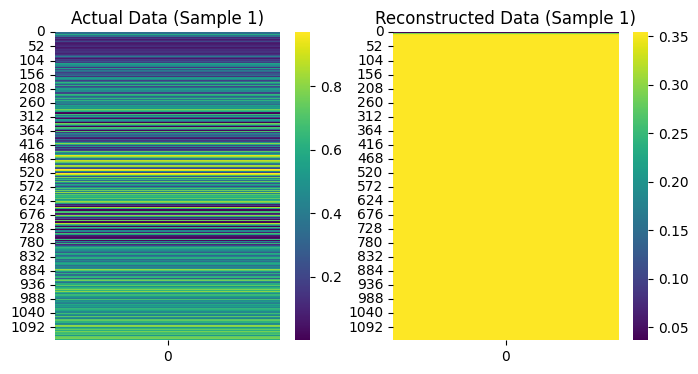

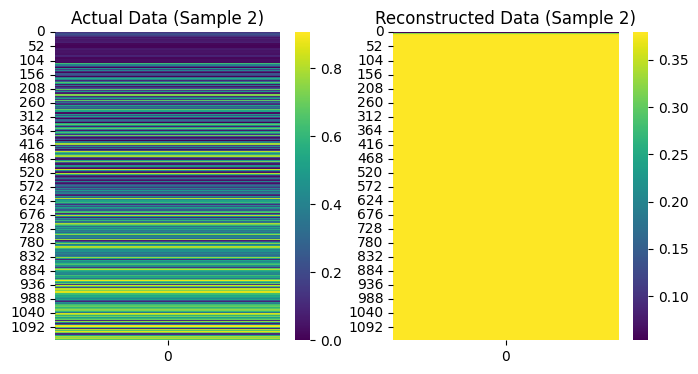

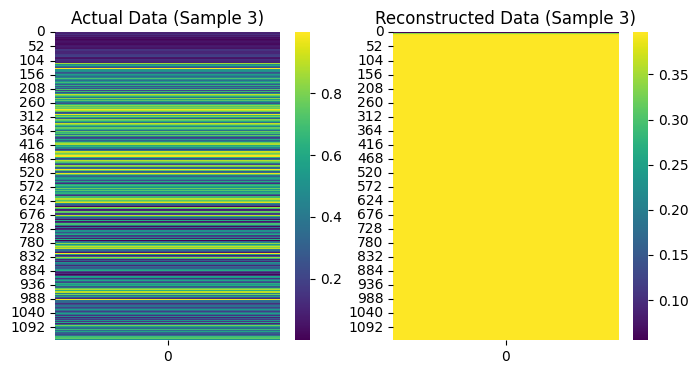

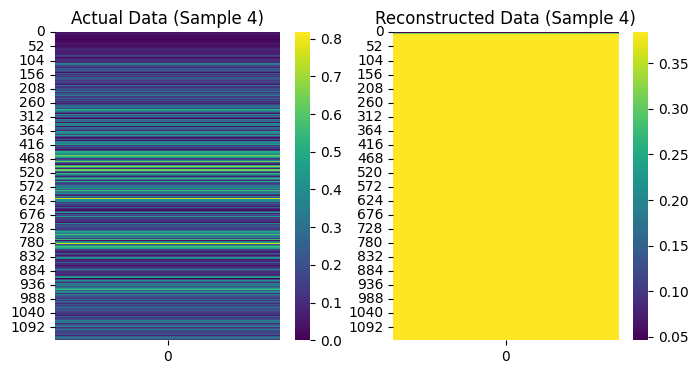

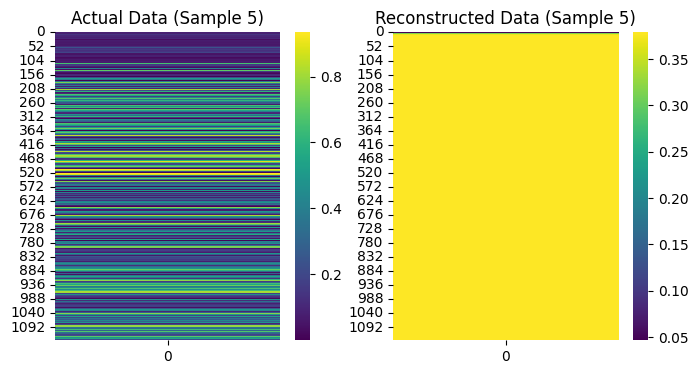

In [24]:
# visualise reconstructions
visualize_actual_vs_reconstructed(cvae, test_loader, num_samples=5)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

def compute_dci(latent_vectors, labels):
    """
    Compute DCI metrics (Disentanglement, Completeness, Informativeness).

    Parameters:
    - latent_vectors: Numpy array of shape (num_samples, latent_dim)
    - labels: Numpy array of shape (num_samples, num_factors) with target factors

    Returns:
    - metrics: Dictionary containing disentanglement, completeness, and informativeness
    """
    num_latent_dims = latent_vectors.shape[1]
    num_factors = labels.shape[1]

    importance_matrix = np.zeros((num_latent_dims, num_factors))
    informativeness_scores = []

    for i in range(num_factors):
        # Train a logistic regression model for each factor
        factor_labels = labels[:, i]
        model = LogisticRegression(max_iter=1000)
        model.fit(latent_vectors, factor_labels)

        # Record importance scores (coefficients)
        importance_matrix[:, i] = np.abs(model.coef_).mean(axis=0)

        # Compute informativeness (accuracy)
        predictions = model.predict(latent_vectors)
        informativeness_scores.append(accuracy_score(factor_labels, predictions))

    # Normalize importance matrix
    importance_matrix /= importance_matrix.sum(axis=0, keepdims=True)

    # Disentanglement
    disentanglement_scores = 1.0 - importance_matrix.var(axis=1)
    disentanglement = disentanglement_scores.mean()

    # Completeness
    completeness_scores = 1.0 - importance_matrix.var(axis=0)
    completeness = completeness_scores.mean()

    # Informativeness
    informativeness = np.mean(informativeness_scores)

    return {
        "disentanglement": disentanglement,
        "completeness": completeness,
        "informativeness": informativeness
    }

# Example Usage
cvae.eval()
latent_vectors = []
labels = []

# Extract latent representations and labels
with torch.no_grad():
    for batch in train_loader:
        x, c = batch[0].to(device), batch[1].to(device)
        mu, _ = cvae.encode(x, c)
        latent_vectors.append(mu.cpu().numpy())
        labels.append(c.cpu().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

# Compute DCI metrics
dci_metrics = compute_dci(latent_vectors, labels)
print("DCI Metrics:", dci_metrics)


DCI Metrics: {'disentanglement': 0.9985212616126125, 'completeness': 0.9980711234254176, 'informativeness': 0.8947368421052632}


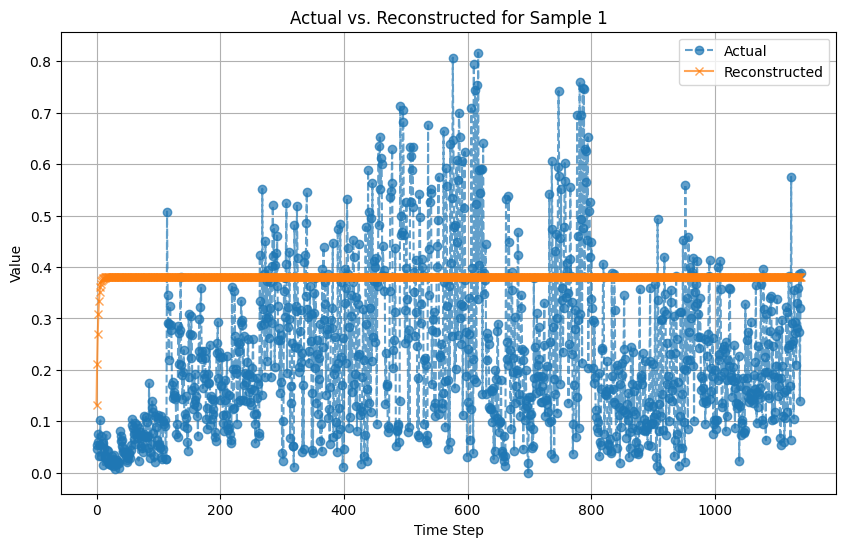

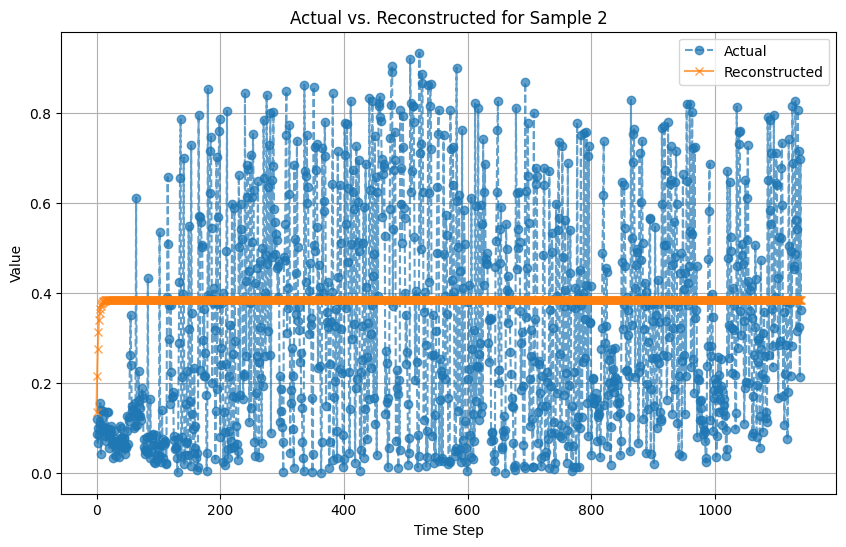

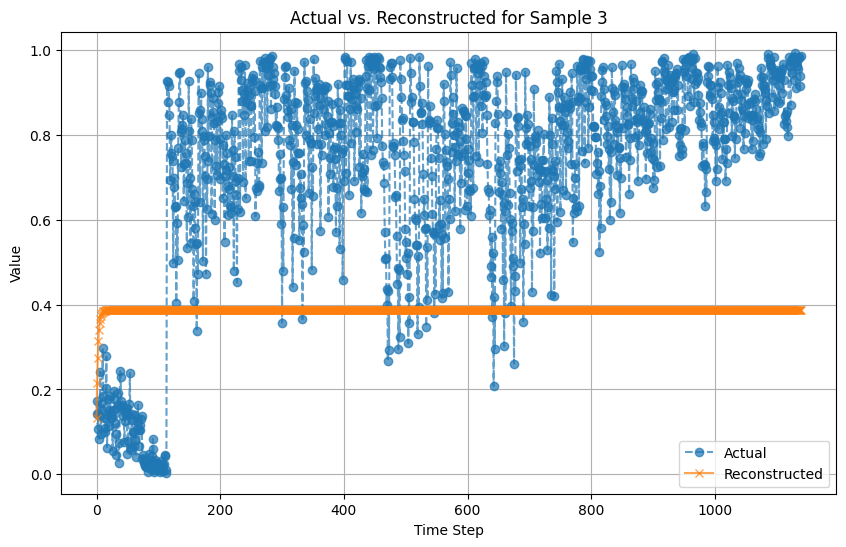

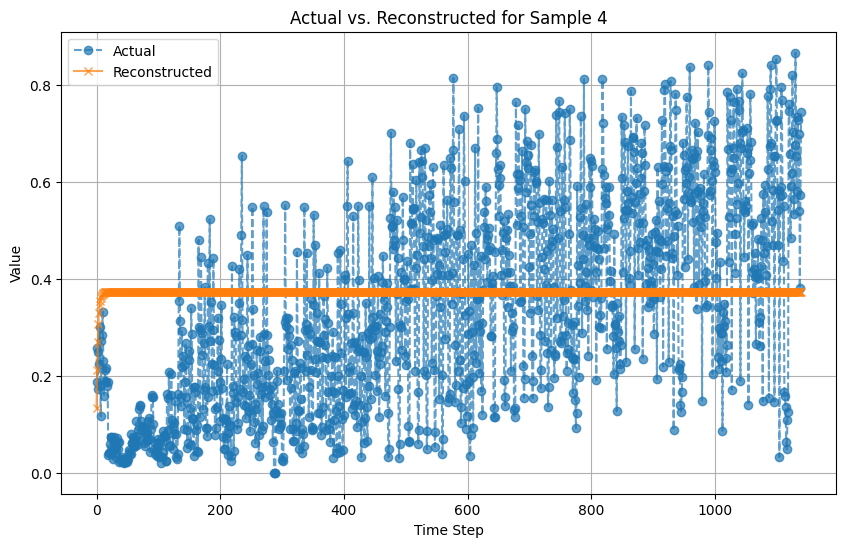

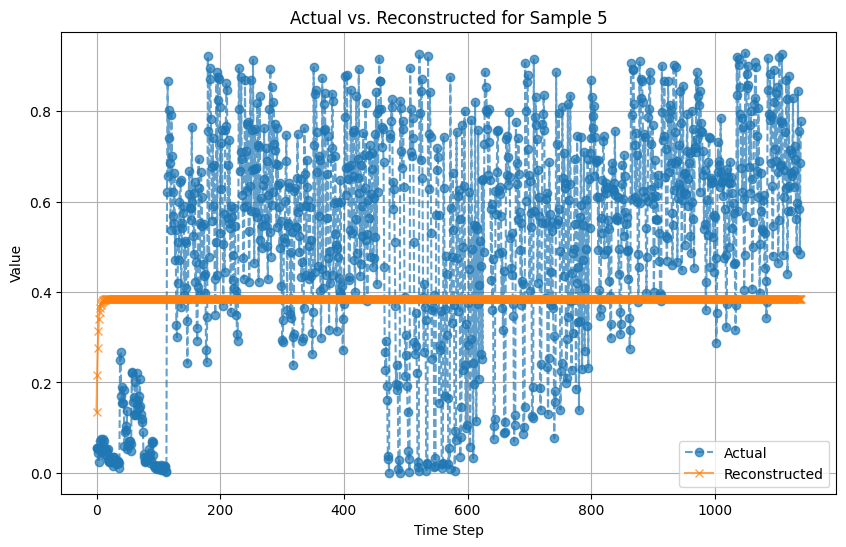

In [21]:
import matplotlib.pyplot as plt

def visualize_actual_vs_reconstructed(model, data_loader, condition_name, num_samples=5):
    """
    Visualize actual and reconstructed time-series data for a specific condition.

    Parameters:
    - model: Trained CVAE model
    - data_loader: DataLoader for the dataset
    - condition_name: Name of the condition to filter
    - num_samples: Number of samples to visualize
    """
    model.eval()
    actual_data = []
    reconstructed_data = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            x, c = batch[0].to(device), batch[1].to(device)

            # Find samples for the specific condition
            condition_mask = c[:, condition_name] == 1  # Adjust for specific one-hot encoding index
            if condition_mask.sum() == 0:
                continue

            filtered_x = x[condition_mask]
            filtered_c = c[condition_mask]

            # Reconstruct
            recon_x, _, _ = model(filtered_x, filtered_c)

            actual_data.append(filtered_x.cpu().numpy())
            reconstructed_data.append(recon_x.cpu().numpy())
            labels.append(filtered_c.cpu().numpy())

            # Break if enough samples are collected
            if len(actual_data) >= num_samples:
                break

    # Convert lists to arrays
    actual_data = np.concatenate(actual_data, axis=0)
    reconstructed_data = np.concatenate(reconstructed_data, axis=0)

    # Plot actual vs reconstructed
    for i in range(num_samples):
        plt.figure(figsize=(10, 6))
        plt.plot(actual_data[i].squeeze(), label="Actual", linestyle="--", marker="o", alpha=0.7)
        plt.plot(reconstructed_data[i].squeeze(), label="Reconstructed", linestyle="-", marker="x", alpha=0.7)
        plt.title(f"Actual vs. Reconstructed for Sample {i+1}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.grid()
        plt.show()

# Example Usage
condition_index = 0  # Replace with the index for a specific disorder
visualize_actual_vs_reconstructed(cvae, test_loader, condition_name=condition_index, num_samples=5)
